In [30]:
%matplotlib inline
import pylab
import seaborn as sns
import cPickle as pickle
import matplotlib.pyplot as plt
import numpy as np
import sys
sns.set_context("paper")
rc={'xtick.labelsize': 22, 'ytick.labelsize': 22}
sns.set(rc=rc)
sns.set_style(style='whitegrid')

## Replicated Bayesian Model

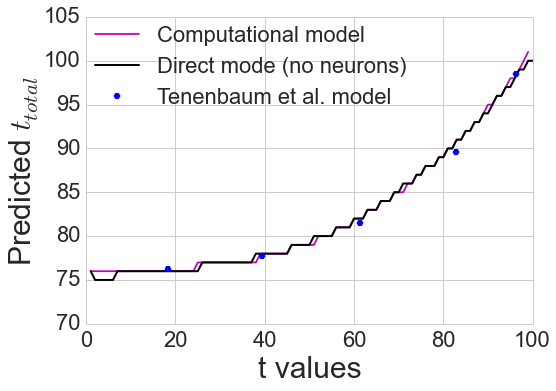

In [31]:
import scipy.stats as st
import scipy.special as sp

max_age = 120 
loc = 99   
scale = 27 
skew = -6  
thetas = np.linspace(start=1, stop=max_age, num=max_age)   # all possible values of theta (from 1 to 120)
p_theta = [(st.skewnorm.pdf(p, a=skew, loc=loc, scale=scale)) for p in thetas]  # prior probability: p(theta)
p_theta = p_theta/np.sum(p_theta)    # normalize prior 


def median(posterior):
    median = 0
    for a in np.arange(len(posterior)):
        cum = sum(posterior[:a+1])
        if cum == 0.5 or cum > 0.5:
            median = a + 1
            break
    return median


predictions = []
for x in np.arange(1,100,1):
    likelihood = [1/p for p in thetas]  #  p(X/theta)
    likelihood[0:x-1] = [0]*(x-1)  # likelihood is 1/theta for theta >= x and 0 otherwise
    p_x = np.sum(np.multiply(p_theta, likelihood))       
    posterior = np.multiply(p_theta, likelihood) / p_x   #normalize posterior
    prediction = median(posterior)
    predictions.append(prediction)
    
plt.figure()
plt.plot(np.arange(1,100,1), predictions, 'm', label="Computational model")
plt.xlabel("t values", fontsize=30)
plt.ylabel("Predicted $t_{total}$", fontsize=30)
    
# pickle file containing neural model results
import cPickle as pickle
 
fname = "neural_predictions_direct99276.p"
data = pickle.load(open(fname, 'rb'))

node_predictions = []
obs_age = []
for key, value in data.items():
    obs_age.append(key)
    node_predictions.append(value[1])
    
plt.plot(obs_age, node_predictions, 'k', linewidth=2.0, label="Direct mode (no neurons)")   

x_tm = [18.248, 39.416, 61.314, 82.847, 96.350]
y_tm = [76.296, 77.777, 81.481, 89.630, 98.519]

tenenbaum_model = plt.plot(x_tm, y_tm, 'bH', linewidth=2.0, label="Tenenbaum et al. model")  

plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., fontsize=22)
plt.savefig('replication.pdf', bbox_inches='tight', dpi=300)

## Prediction Results

In [32]:
# Human data obtained from from Griffiths and Tenenbaum (2006)
x_h = [18.248, 39.416, 61.314, 82.847, 96.350]
y_h = [74.074 ,74.815, 77.037, 90.000, 98.519] 


# pickle file containing neural model results for Direct mode
fname = "neural_predictions_direct99276.p" 
data = pickle.load(open(fname, 'rb'))

node_predictions_direct = []
obs_age = []
for key, value in data.items():
    obs_age.append(key)
    node_predictions_direct.append(value[1])

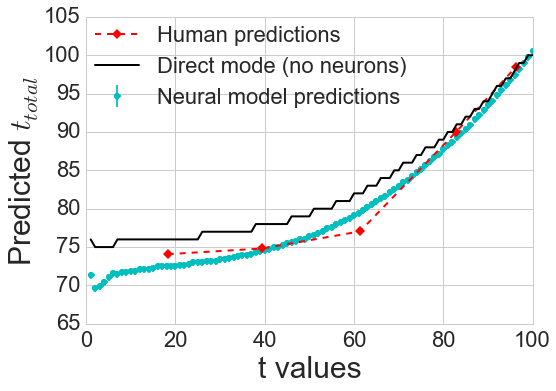

In [44]:
#Confidence Interval
from matplotlib import pyplot as plt
from scipy.stats import t
from scipy import stats
import math
 
# make a tuple of all the runs
sample_size = 31
node_predictions_list = []
for sample in range(sample_size):
    fname = "final_data/neural_predictions500_99276_" + str(sample) + ".p"
    data = pickle.load(open(fname, 'rb'))
    node_predictions = []
    for key, value in data.items():
        node_predictions.append(value[1])
    node_predictions_list.append(node_predictions)
        
X = tuple(node_predictions_list) 

# number of samples
sample_size = len(X)

# mean
X_mean = np.mean(X, axis=0)

# standard deviation
X_std = np.std(X, axis=0)

# standard error
X_se = np.divide(X_std, np.sqrt(sample_size))


# 95% Confidence Interval
intervals = []
z_critical = stats.norm.ppf(q = 0.975)  # Get the z-critical value*


margin_of_error = z_critical * (X_std/math.sqrt(sample_size))

intervals = []
for sample in range(100):
    confidence_interval = (X_std[sample] - margin_of_error[sample],
                           X_std[sample] + margin_of_error[sample]) 
    
    intervals.append(confidence_interval)

#plt.figure(figsize=(7,7))

plt.errorbar(x=np.arange(1, 101, 1), 
             y=X_mean, 
             yerr=[(top-bot)/2 for top,bot in intervals],
             fmt='co', label="Neural model predictions")
human = plt.plot(x_h, y_h, 'rD--', linewidth=2.0, label="Human predictions")
plt.plot(obs_age, node_predictions_direct, 'k', linewidth=2.0, label="Direct mode (no neurons)")

plt.xlabel("t values", fontsize=30)
plt.ylabel("Predicted $t_{total}$", fontsize=30)
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., fontsize=22)
plt.savefig('nengo_predictions.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [34]:
# Computing the sample size
min_margin_of_error = 0.32
max_X_std = max(X_std)
required_sample_size = math.pow((float(z_critical)*max_X_std / min_margin_of_error),2)
print "Required sample size: ", required_sample_size

Required sample size:  28.593947415


## Kolmogorov-Smirnov (K-S)

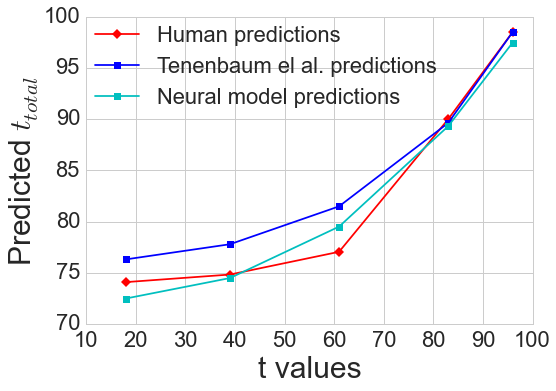

In [43]:
# Kolmogorov-Smirnov (K-S) test plots
x = [18, 39, 61, 83, 96]
y_human = [74.074 ,74.815, 77.037, 90.000, 98.519]
y_comp = [76.296, 77.777, 81.481, 89.630, 98.519]
y_neural = X_mean[[k-1 for k in x]]
  
plt.figure()
plt.plot(x, y_human, 'rD-', label = "Human predictions")
plt.plot(x, y_comp, 'bs-', label = "Tenenbaum el al. predictions")
plt.xlabel("t values", fontsize=25)
plt.ylabel("Predicted $t_{total}$", fontsize=25)
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., fontsize=18)
plt.savefig('kolmogrov_comp.pdf', bbox_inches='tight', dpi=300)

#plt.figure()
plt.plot(x, y_neural, 'cs-', label = "Neural model predictions")
plt.xlabel("t values", fontsize=30)
plt.ylabel("Predicted $t_{total}$", fontsize=30)
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., fontsize=22)
plt.savefig('kolmogrov_results.pdf', bbox_inches='tight', dpi=300)

## Neuron Types

In [36]:
# pickle file containing LIFRate neural model results
fname = "neural_predictions800_LIFRate99276.p" 
data = pickle.load(open(fname, 'rb'))

node_predictions_LIFRate = []
obs_age = []
for key, value in data.items():
    obs_age.append(key)
    node_predictions_LIFRate.append(value[1])


# pickle file containing LIF neural model results
fname = "neural_predictions800_LIF99276.p" 
data = pickle.load(open(fname, 'rb'))

node_predictions_LIF= []
obs_age = []
for key, value in data.items():
    obs_age.append(key)
    node_predictions_LIF.append(value[1])

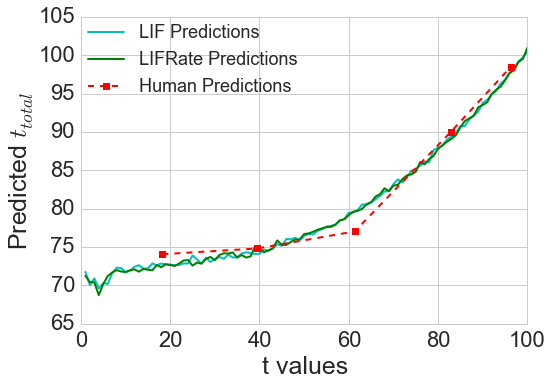

In [37]:
plt.figure()
nengo_model = plt.plot(obs_age, node_predictions_LIF, 'c', linewidth=2.0, label="LIF Predictions")
plt.plot(obs_age, node_predictions_LIFRate, 'g', linewidth=2.0, label="LIFRate Predictions")
human = plt.plot(x_h, y_h, 'rs--', linewidth=2.0, label="Human Predictions")
plt.xlabel("t values", fontsize=25)
plt.ylabel("Predicted $t_{total}$", fontsize=25)
plt.savefig('neuron_types.pdf', bbox_inches='tight', dpi=300)
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., fontsize=18)
plt.show()